In [1]:
# Imports
%matplotlib inline
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
from scipy.optimize import curve_fit

In [3]:
### Baseline Corrector and Transition Range Fitting

### General Functions
def simple_scaler(y):
    """
    Simple min/max scaling to range 0-1
    """
    y_min = np.min(y)
    y_max = np.max(y)
    return (y - y_min)/(y_max - y_min)

def calculate_free_calcium(edta_ratio, total_ca=500e-6, ln_kf=10.65):
    """
    Calculate free calcium concentration given EDTA:Ca ratio
    edta_ratio: [EDTA]/[Ca] ratio
    total_ca: total calcium concentration (M)
    ln_kf: natural log of formation constant for EDTA-Ca complex
    Returns: free calcium concentration (M)
    """
    Kf = np.exp(ln_kf)  
    total_edta = edta_ratio * total_ca
    
    a = Kf
    b = (Kf * total_edta - Kf * total_ca + 1)
    c = -total_ca
    
    free_ca = (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)
    return free_ca

def hill_equation(x, K, n, y_min):
    """
    Hill equation for calcium binding with baseline offset
    x: free [Ca²⁺] (M)
    K: dissociation constant (M)
    n: Hill coefficient
    y_min: baseline offset
    """
    return y_min + (1-y_min) * (x**n / (K**n + x**n))

def baseline_corrector(filepath, x_col, y_col, left_start, left_end, right_start, right_end):
    """
    Transform data using baseline correction and scaling, using explicit boundary points
    for baseline fits. Handles file operations internally.
    
    Parameters:
    -----------
    filepath : str
        Path to CSV file containing data
    x_col : str
        Name of x-axis column in CSV
    y_col : str
        Name of y-axis column in CSV
    left_start : int
        Starting index for left baseline region
    left_end : int
        Ending index for left baseline region
    right_start : int
        Starting index for right baseline region
    right_end : int
        Ending index for right baseline region
    
    Returns:
    --------
    tuple containing:
        corrected_data : array
            Baseline corrected and scaled data
        signal_name : str
            Name of the signal being processed
        fig : matplotlib figure
            Figure handle for the visualization plot
        df_output : DataFrame
            DataFrame containing x column and corrected signal
        file_paths : dict
            Dictionary containing output file paths
        parameters: dict
            Dictionary containing the baseline parameters used
    """
    # Read data
    try:
        df = pd.read_csv(filepath)
    except Exception as e:
        raise Exception(f"Error reading {filepath}: {str(e)}")
    
    # Extract x and y data
    if x_col not in df.columns or y_col not in df.columns:
        raise ValueError(f"Columns {x_col} and/or {y_col} not found in CSV file")
    
    # Extract data excluding first and last points
    x_full = df[x_col].iloc[1:-1].to_numpy(dtype=float)
    y_full = df[y_col].iloc[1:-1].to_numpy(dtype=float)
    
    # Fit left baseline
    left_coefs = poly.polyfit(x_full[left_start:left_end], 
                             y_full[left_start:left_end], 1)
    left_b = left_coefs[0]
    left_m = left_coefs[1]
    left_line = left_m*x_full + left_b
    
    # Fit right baseline
    right_coefs = poly.polyfit(x_full[right_start:right_end], 
                              y_full[right_start:right_end], 1)
    right_b = right_coefs[0]
    right_m = right_coefs[1]
    right_line = right_m*x_full + right_b
    
    # Apply baseline correction
    y_baseline = (y_full - right_line)/(left_b - right_b)
    
    # Apply min/max scaling
    y_final = simple_scaler(y_baseline)
    
    # Create visualization
    fig = plt.figure(figsize=(30, 9))
    
    # Calculate y-axis limits with padding
    y_min = np.min(y_full)
    y_max = np.max(y_full)
    y_range = y_max - y_min
    padding = 3 * y_range
    plot_y_min = y_min - padding
    plot_y_max = y_max + padding
    
    # Panel 1: Original data with baselines
    ax1 = fig.add_subplot(131)
    ax1.scatter(x_full, y_full, s=50, facecolor='none', edgecolor='black', label='Data')
    
    # Plot baselines
    ax1.plot(x_full, poly.polyval(x_full, left_coefs), '-', color="blue", 
            label=f'Left baseline ({left_end-left_start} points)')
    ax1.plot(x_full, poly.polyval(x_full, right_coefs), '-', color="red",
            label=f'Right baseline ({right_end-right_start} points)')
    
    # Highlight baseline points
    ax1.scatter(x_full[left_start:left_end], y_full[left_start:left_end], 
                color='blue', s=100, alpha=0.3)
    ax1.scatter(x_full[right_start:right_end], y_full[right_start:right_end], 
                color='red', s=100, alpha=0.3)
    
    ax1.set_ylim(plot_y_min, plot_y_max)
    ax1.set_title("Original Data with Baselines")
    ax1.set_xlabel(x_col)
    ax1.set_ylabel(y_col)
    ax1.legend()
    
    # Panel 2: Baseline corrected and scaled data
    ax2 = fig.add_subplot(132)
    ax2.scatter(x_full, y_final, color='black', alpha=0.5, label='Corrected data')
    ax2.set_title("Baseline Corrected & Scaled")
    ax2.set_xlabel(x_col)
    ax2.set_ylabel(f"Corrected {y_col}")
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.set_ylim(0, 1)
    ax2.legend()
    
    # Panel 3: Simply scaled data (no baseline correction)
    ax3 = fig.add_subplot(133)
    y_scaled = simple_scaler(y_full)
    ax3.scatter(x_full, y_scaled, color='black', alpha=0.5, label='Scaled data')
    ax3.set_title("Scaled Only (No Baseline Correction)")
    ax3.set_xlabel(x_col)
    ax3.set_ylabel(f"Scaled {y_col}")
    ax3.grid(True, linestyle='--', alpha=0.7)
    ax3.set_ylim(0, 1)
    ax3.legend()
    
    plt.suptitle(f"Analysis of {y_col} vs {x_col}")
    plt.tight_layout()
    
    # Setup output paths
    date = Path(filepath).stem
    folder = os.path.basename(os.path.dirname(filepath))
    csv_dir = os.path.dirname(filepath)
    
    output_plot = f"{date}_{folder}_{y_col}.png"
    output_csv = f"{date}_corrected_{y_col}.csv"
    
    plot_path = os.path.join(csv_dir, output_plot)
    csv_path = os.path.join(csv_dir, output_csv)
    
    # Create output dataframe
    df_output = pd.DataFrame({
        x_col: df[x_col].iloc[1:-1],
        y_col: y_final
    })
    
    # Store the baseline parameters used
    parameters = {
        'left_start': left_start,
        'left_end': left_end,
        'right_start': right_start,
        'right_end': right_end,
        'csv_dir': csv_dir
    }
    
    return (y_final, y_col, fig, df_output, 
            {"plot": plot_path, "csv": csv_path, "dir": csv_dir}, 
            parameters)

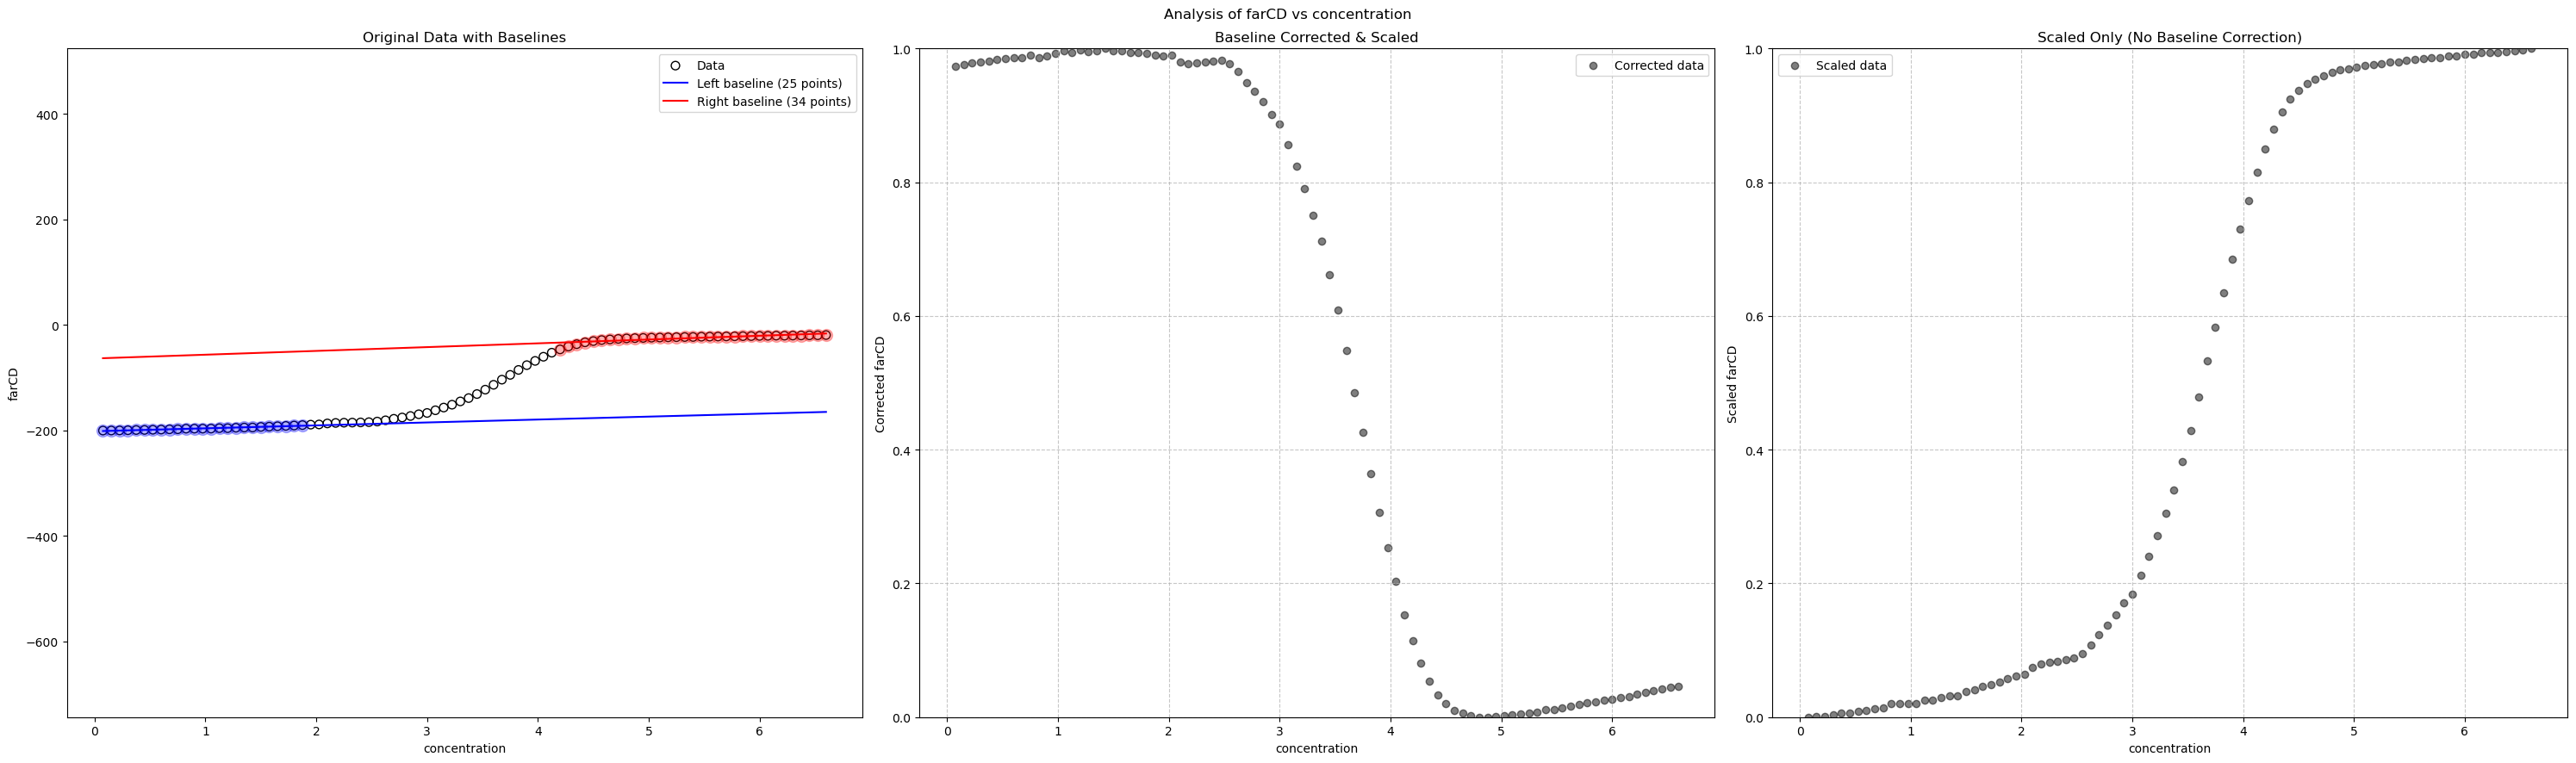

In [4]:
## Running/Visualizing Baseline Correction

csv = r"C:\Users\willi\Desktop\20251009_hA4_F55A_Urea_75uMCa\data.csv"
# Get the directory containing the CSV file
csv_dir = os.path.dirname(csv)

corrected_data, signal, fig, df_output, file_paths, parameters = baseline_corrector(
    csv,
    "concentration",
    "farCD",
    left_start=0,
    left_end=25,
    right_start=55,
    right_end=89
)
plt.show()

In [18]:
## Save the baseline correction as a picture and a csv of the scaled values

fig.savefig(file_paths["plot"], dpi=600, bbox_inches='tight')
df_output.to_csv(file_paths["csv"], index=False)